# Day 12: Correlation Analysis

1. Overview  
2. Load & Prepare Data  
3. Merge Solar & Generation  
4. Compute Correlation Matrix  
5. Visualize Correlations (Heatmap)  
6. Pairwise Scatter Matrix  

---

## 1. Overview

Today’s goals are to:

- Merge solar‑irradiance and generation datasets at a common monthly granularity  
- Compute Pearson correlation coefficients among irradiance, total generation, and source‑specific generation  
- Visualize relationships via a heatmap and pairwise scatter matrix  

---

## 2. Load & Prepare Data

In this section, I will:

- Import `pandas`  
- Load my daily `solar_irr.csv` and aggregate to monthly averages  
- Load my `cea_generation.csv` and compute monthly total and pivot by fuel type

In [2]:
import pandas as pd

# Load daily solar data
solar = pd.read_csv("../../week1/day6/solar_irr.csv", parse_dates=["date"])
solar["month"] = solar["date"].dt.month

# Compute monthly avg irradiance
solar_monthly = (
    solar.groupby("month")["irradiance_kwh"]
         .mean()
         .rename("avg_irradiance_kwh")
         .reset_index()
)

# Load generation data
gen = pd.read_csv("../day8/cea_generation.csv")
# Pivot to get one column per fuel type per region or just total
gen_total = (
    gen.groupby("month")["generation"]
       .sum()
       .rename("total_generation_mu")
       .reset_index()
)

# Pivot by fuel type:
gen_fuel = gen.pivot_table(
    index="month",
    columns="fuel_type",
    values="generation"
).reset_index()

---

## 3. Merge Solar & Generation

In this section, I will:

- Merge the monthly solar and total generation DataFrames on `month`  
- Merge in fuel‑specific generation columns for a unified analysis table

In [3]:
# Merge overall
df = pd.merge(solar_monthly, gen_total, on="month")

# Merge fuel‐specific
df = pd.merge(df, gen_fuel, on="month")

df


,month,avg_irradiance_kwh,total_generation_mu,Hydro,Solar,Wind
0,1,3.194194,1325.88,284.980,233.19,144.770
1,2,4.313571,1796.42,353.195,253.63,291.385
2,3,5.804194,1809.12,345.550,440.32,118.690
3,4,6.658000,1379.07,232.165,245.59,211.780


---

## 4. Compute Correlation Matrix

In this section, I will:

- Use `df.corr()` to calculate Pearson correlation coefficients among:
  - `avg_irradiance_kwh`
  - `total_generation_mu`
  - `Solar`, `Wind`, `Hydro` columns

In [4]:
corr_matrix = df.corr()
print(corr_matrix)

                        month  avg_irradiance_kwh  total_generation_mu  \
month                1.000000            0.995187             0.085232   
avg_irradiance_kwh   0.995187            1.000000             0.133746   
total_generation_mu  0.085232            0.133746             1.000000   
Hydro               -0.377700           -0.324217             0.887346   
Solar                0.293587            0.384189             0.648261   
Wind                 0.047392           -0.025504             0.210794   

                        Hydro     Solar      Wind  
month               -0.377700  0.293587  0.047392  
avg_irradiance_kwh  -0.324217  0.384189 -0.025504  
total_generation_mu  0.887346  0.648261  0.210794  
Hydro                1.000000  0.520515  0.100459  
Solar                0.520515  1.000000 -0.562589  
Wind                 0.100459 -0.562589  1.000000  


---

## 5. Visualize Correlations (Heatmap)

In this section, I will:

- Plot the correlation matrix as a heatmap  
- Annotate each cell with the correlation value for clarity

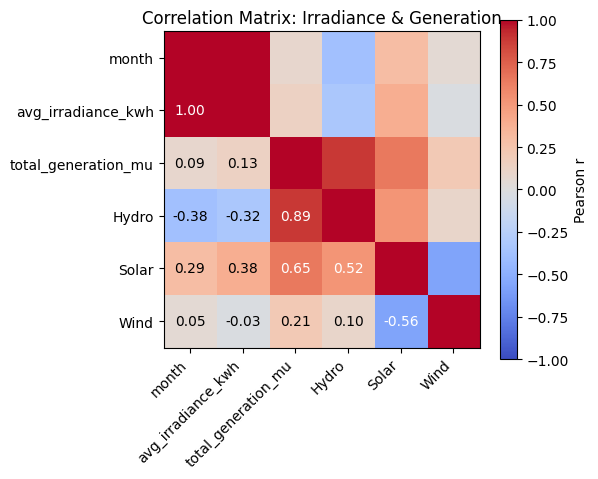

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,5))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="Pearson r")
ticks = range(len(corr_matrix.columns))
plt.xticks(ticks, corr_matrix.columns, rotation=45, ha="right")
plt.yticks(ticks, corr_matrix.columns)
for i in ticks:
    for j in ticks:
        if not mask[i, j]:
            plt.text(j, i, f"{corr_matrix.iloc[i,j]:.2f}",
                     ha="center", va="center", color="white" if abs(corr_matrix.iloc[i,j])>0.5 else "black")
plt.title("Correlation Matrix: Irradiance & Generation")
plt.tight_layout()
plt.show()

---

## 6. Pairwise Scatter Matrix

In this section, I will:

- Use Pandas’ `scatter_matrix()` to generate a grid of scatter plots  
- Inspect pairwise relationships and potential outliers between variables

<Figure size 800x800 with 0 Axes>

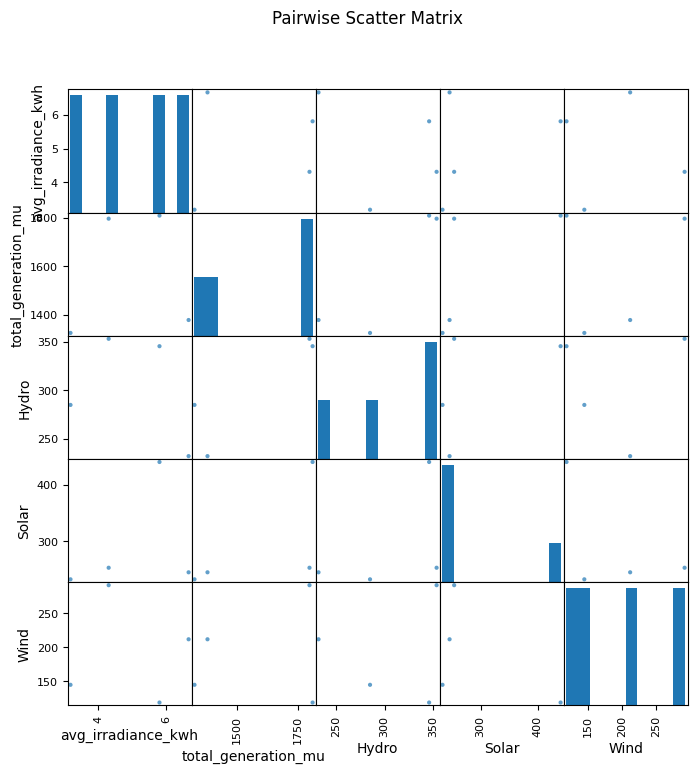

In [6]:
from pandas.plotting import scatter_matrix

plt.figure(figsize=(8,8))
scatter_matrix(df.drop("month", axis=1), diagonal="hist", alpha=0.7, figsize=(8,8))
plt.suptitle("Pairwise Scatter Matrix")
plt.show()